In [175]:
# Import librarys
from run_ac import *
import os
from tqdm import tqdm
import time
from func import *
import geopandas as gpd
from matplotlib import pyplot as plt

In [176]:
# Read in forcing data
years = np.arange(2000, 2024, 1)
P_data = []
R_data = []
T_data = []
lai_data = []
calibration_time = [2000, 2010]

for year in years:
    file_path = 'data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    P_data.append(xr.open_dataset(file_path)['tp'])

    file_path = 'data/net_radiation/nr.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    R_data.append(xr.open_dataset(file_path)['nr'])

    file_path = 'data/daily_average_temperature/t2m_mean.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    T_data.append(xr.open_dataset(file_path)['t2m'])

    file_path = 'data/lai/lai.daily.0d50_CentralEurope.' + str(year) + '.nc'
    lai_data.append(xr.open_dataset(file_path)['lai'])

# Convert lists to xarray datasets
P_data = xr.concat(P_data, dim='time')
R_data = xr.concat(R_data, dim='time')
T_data = xr.concat(T_data, dim='time')
lai_data = xr.concat(lai_data, dim='time')

In [177]:
# Replace the timestamp from LAI
new_time_range = pd.date_range(start='2000-01-01', end='2023-12-31', freq='D')
lai_data['time'] = new_time_range

# Replace first 48 days with them from 2001
torep = lai_data.sel(time = slice("2001-01-01","2001-02-17"))
lai_data.values[0:48, :, :] = torep.values

# Fill gaps in LAI
for lat in range(len(P_data.lat)):
    for lon in range(len(P_data.lon)):
        if np.isnan(lai_data[:, lat, lon]).all():
            continue
        else:
            # Get the data for the current grid cell
            grid_cell_data = lai_data[:, lat, lon]
            
            # Convert to DataFrame for easier handling
            grid_cell_df = pd.DataFrame(grid_cell_data)
            
            # Fill NA values with the previous value
            grid_cell_df.fillna(method='ffill', inplace=True)
            
            # Update the grid cell data
            lai_data[:, lat, lon] = grid_cell_df.values.flatten()

C:\Users\motze\AppData\Local\Temp\ipykernel_18424\3949883917.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ffill', inplace=True)
C:\Users\motze\AppData\Local\Temp\ipykernel_18424\3949883917.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ffill', inplace=True)
C:\Users\motze\AppData\Local\Temp\ipykernel_18424\3949883917.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ffill', inplace=True)
C:\Users\motze\AppData\Local\Temp\ipykernel_18424\3949883917.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method

In [178]:
# Prepare data for new model
full_data = np.full((22, 22, 8766, 4), np.nan)
#full_data = np.zeros((22, 22, 8766, 4))

full_data[:, :, :, 0] = P_data.transpose('lat', 'lon', 'time')
full_data[:, :, :, 1] = R_data.transpose('lat', 'lon', 'time')
full_data[:, :, :, 2] = T_data.transpose('lat', 'lon', 'time')
full_data[:, :, :, 3] = lai_data.transpose('latitude', 'longitude', 'time')

## Run model with present data

In [179]:
params = [420, 8, 0.2, 0.8, 1.5, (0.75, 0.25)]
results = time_evolution(full_data, *params)

current = out2xarray(results)

c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:35: RuntimeWarning: invalid value encountered in divide
  normalized_lai = (lai - lai_min) / (lai_max - lai_min)


start_timeevolution


100%|██████████| 8766/8766 [00:01<00:00, 7816.39it/s]
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  out_xr = xr.DataArray(output[:, :, :, i], dims=('time', 'lat', 'lon'),
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.dateti

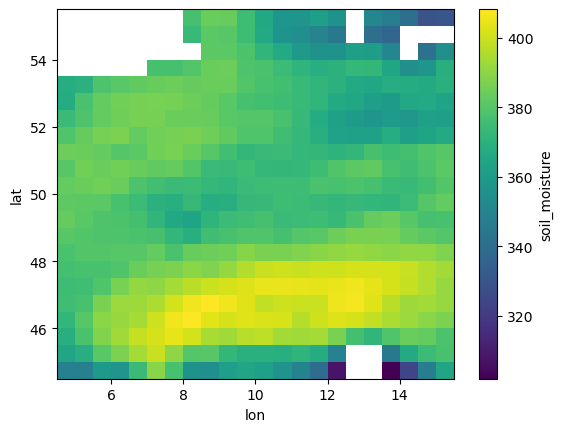

In [180]:
current['soil_moisture'].mean(dim='time').plot()

## Get and prepare future data

In [192]:
# Load projection data
lai_sel  = xr.open_dataarray(r"C:\Users\motze\Desktop\monthly\LeafAreaIndex_2000_2100_cropeed_offset.nc")
P_sel  = xr.open_dataarray(r"C:\Users\motze\Desktop\monthly\precipitation_converted.nc")
R_sel  = xr.open_dataarray(r"C:\Users\motze\Desktop\monthly\Radation_converted.nc")
T_sel  = xr.open_dataarray(r"C:\Users\motze\Desktop\monthly\Temperature_2000_2100_cropped_offset.nc")

In [193]:
new_time_range = pd.date_range(start='2000', end='2101', freq='M')
lai_sel['time'] = new_time_range
P_sel['time'] = new_time_range
R_sel['time'] = new_time_range
T_sel['time'] = new_time_range

C:\Users\motze\AppData\Local\Temp\ipykernel_18424\3191186906.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  new_time_range = pd.date_range(start='2000', end='2101', freq='M')


In [194]:
# Select only 2024 to 2100
lai_future = lai_sel.sel(time = slice("2076-12-31","2100"))
T_future = T_sel.sel(time = slice("2076-12-31","2100"))
R_future = R_sel.sel(time = slice("2076-12-31","2100"))
P_future = P_sel.sel(time = slice("2076-12-31","2100"))

In [89]:
P_data['time'] = P_future['time']

In [196]:
# Prepare data for new model
full_data_future = np.full((22, 22, len(P_future), 4), np.nan)
#full_data_future = np.zeros((22, 22, len(P_future), 4))

full_data_future[:, :, :, 0] = P_future.transpose('lat', 'lon', 'time')
full_data_future[:, :, :, 1] = R_future.transpose('lat', 'lon', 'time')
full_data_future[:, :, :, 2] = T_future.transpose('lat', 'lon', 'time')
full_data_future[:, :, :, 3] = lai_future.transpose('lat', 'lon', 'time')

## Run model with future data

In [198]:
params = [420, 8, 0.2, 0.8, 1.5, (0.75, 0.25)]
results_future = time_evolution(full_data_future, *params)

#future = out2xarray2(results_future, P_future)

start_timeevolution


  0%|          | 0/289 [00:00<?, ?it/s]

100%|██████████| 289/289 [00:00<00:00, 6349.88it/s]


In [185]:
def out2xarray2(output, reference):
    output = np.moveaxis(output, 2, 0)  # move time axis to be first axis

    # get dates and coordinates
    times = reference['time']
    lons = reference.lon.values
    lats = reference.lat.values
    
    out_dict = {}
    for i, out_name in enumerate(['runoff',
                                  'evapotranspiration',
                                  'soil_moisture',
                                  'snow']):
        out_xr = xr.DataArray(output[:, :, :, i], dims=('time', 'lat', 'lon'),
                              coords={'time': times,
                                      'lat': lats,
                                      'lon': lons})
        out_dict[out_name] = out_xr

    return xr.Dataset(out_dict)

In [200]:
future = out2xarray2(results_future, P_future)

## Show results

In [187]:
def split_seasons(data):
    """
    Split the input data into seasons: MAM, JJA, SON, DJF.
    
    Parameters:
        data (xarray.DataArray): Data array with 'time', 'lat', and 'lon' coordinates.
        
    Returns:
        dict: A dictionary containing separate xarray DataArrays for each season.
    """
    # Extract month information from time coordinate
    months = data['time'].dt.month

    # Define seasonal masks
    is_mam = (months >= 3) & (months <= 5)  # MAM: March, April, May
    is_jja = (months >= 6) & (months <= 8)  # JJA: June, July, August
    is_son = (months >= 9) & (months <= 11)  # SON: September, October, November

    # For DJF, we need to handle the wrap-around between December and January
    # Shift the months by one step and check if they are December, January, or February
    shifted_months = months.roll(time=-1)
    is_djf = ((months == 12) | (months == 1) | (months == 2)) & (shifted_months == 12)

    # Initialize dictionary to store seasonal data arrays
    seasonal_data = {}

    # Store seasonal data arrays for each season
    seasonal_data['spring'] = data.sel(time=is_mam)
    seasonal_data['summer'] = data.sel(time=is_jja)
    seasonal_data['autumn'] = data.sel(time=is_son)
    seasonal_data['winter'] = data.sel(time=is_djf)

    return seasonal_data

In [202]:
seasonal_data = split_seasons(current)
seasonal_data_future = split_seasons(future)

In [189]:
def plot_comp(data, data_future, source):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    min_val = min(data[source].mean(dim='time').quantile(0.05).values,
              data_future[source].mean(dim='time').quantile(0.05).values)
    max_val = max(data[source].mean(dim='time').quantile(0.95).values,
                data_future[source].mean(dim='time').quantile(0.95).values)
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the data for the present in the second subplot
    im2 = data[source].mean(dim='time').plot(ax=axs[0], cmap='viridis', vmin=min_val, vmax=max_val)
    axs[0].set_title('Present 2000-2024')

    # Plot the mean soil moisture for the future in the first subplot
    im1 = data_future[source].mean(dim='time').plot(ax=axs[1], cmap='viridis',vmin=min_val, vmax=max_val)
    axs[1].set_title('Future 2076-2100')

    # Plot country boundaries
    world.boundary.plot(ax=axs[0], linewidth=1)
    world.boundary.plot(ax=axs[1], linewidth=1)

    plt.show()

C:\Users\motze\AppData\Local\Temp\ipykernel_18424\2579918408.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


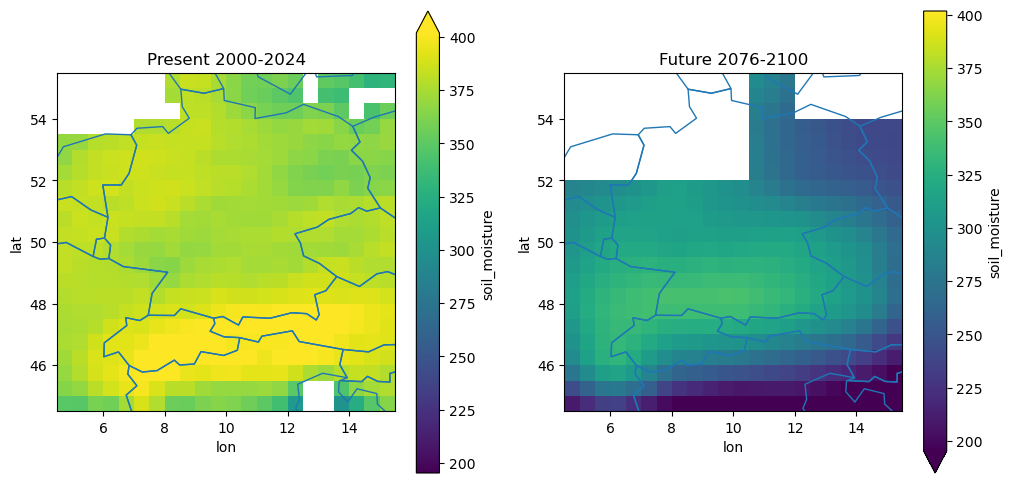

In [201]:
plot_comp(current, future, 'soil_moisture')

C:\Users\motze\AppData\Local\Temp\ipykernel_18424\2579918408.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


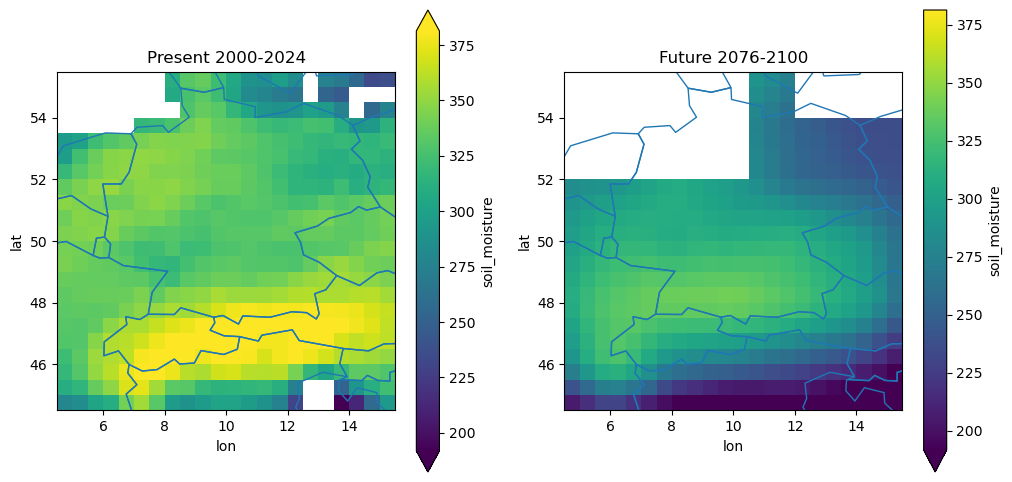

In [205]:
plot_comp(seasonal_data['summer'], seasonal_data_future['summer'], 'soil_moisture')